<a href="https://colab.research.google.com/github/marcelofxavier/MVP-Sprint-Data-engineering/blob/main/MarceloXavier_MVP_DataEngineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MVP - Marcelo Xavier - Data Engineering

#1.Objective
Analyze the factors that influence the academic performance of high school students by creating a data pipeline on a cloud platform.

## Questions
1. Is there a significant difference in academic performance among different demographic groups (age, gender, ethnicity)?
2. How do weekly study time affect students' academic performance?
3. What is the impact of the level of parental support on students' academic performance?
4. Is participation in extracurricular activities, sports, music, and volunteering associated with better academic outcomes?
5. Is there a correlation between parents' education level and students' academic performance?
6. Is there a correlation between absenses and students' academic performance?

# 2. Data Collection

To answer the questions created in the objective, we will use the "Students Performance Dataset" database from Kaggle.


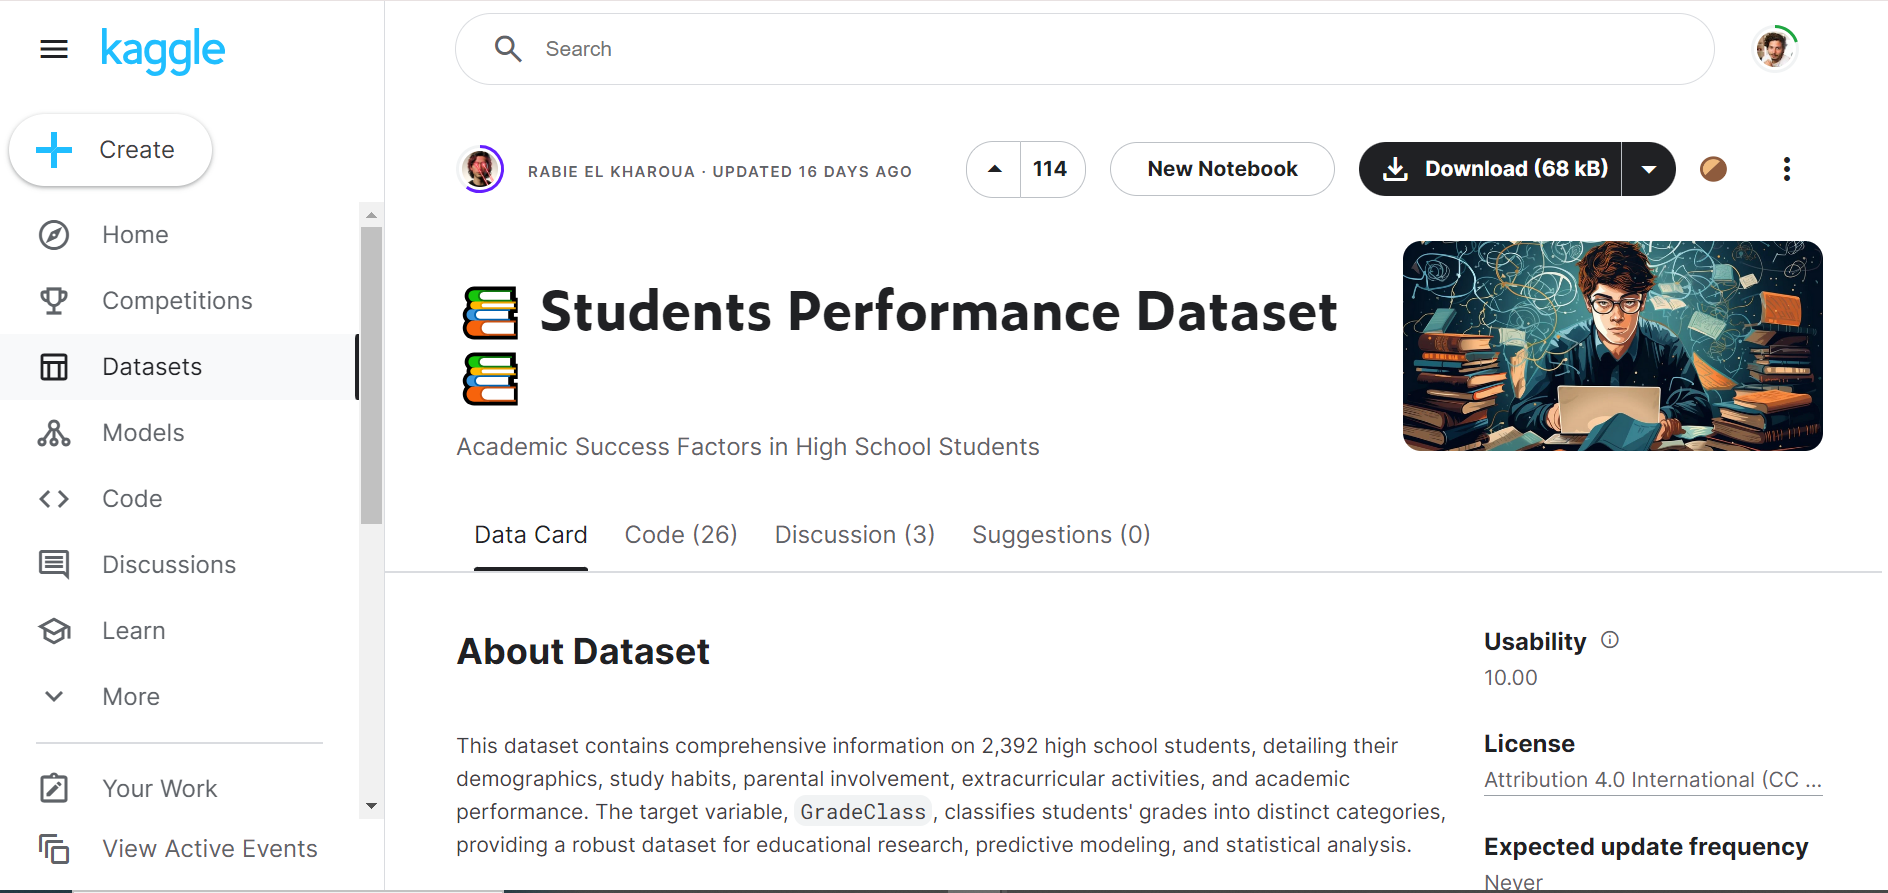

The data was downloaded in CSV format and manually uploaded to Databricks



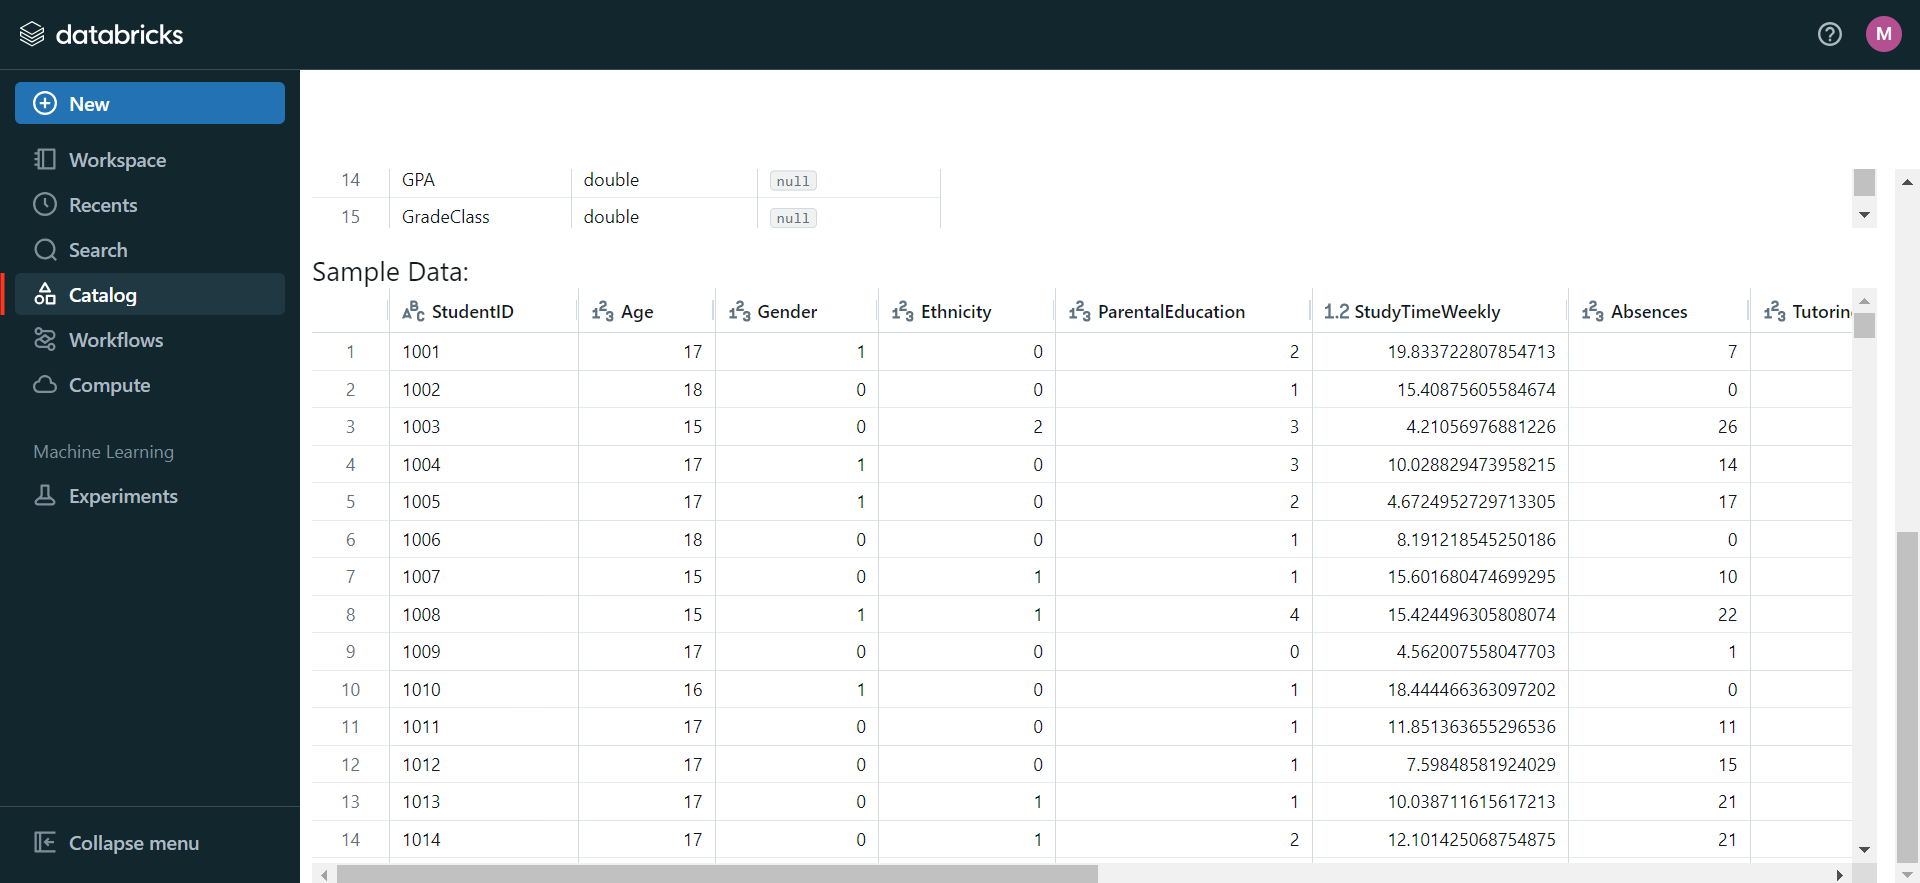

# 3. Modeling

A flat model was created for the collected data

## Data Catalog

This dataset contains comprehensive information on 2.392 high school students with 15 columns:

1. **StudentID**: A unique identifier assigned to each student (1001 to 3392)
2. **Age**: The age of the students ranges from 15 to 18 years.
3. **Gender**: Gender of the students, where 0 represents Male and 1 represents Female.
4. **Ethnicity**: The ethnicity of the students (0: Caucasian, 1: African American, 2: Asian, 3: Other)
5. **ParentalEducation**: The education level of the parents (0: None, 1: High School, 2: Some College, 3: Bachelor's, 4: Higher)
6. **StudyTimeWeekly**: Weekly study time in hours, ranging from 0 to 20.
7. **Absences**: Number of absences during the school year, ranging from 0 to 30.
8. **Tutoring**: Tutoring status, where 0 indicates No and 1 indicates Yes.
9. **ParentalSupport**: The level of parental support (0: None, 1: Low, 2: Moderate, 3: High, 4: Very High)
10. **Extracurricular**: Participation in extracurricular activities, where 0 indicates No and 1 indicates Yes.
11. **Sports**: Participation in sports, where 0 indicates No and 1 indicates Yes.
12. **Music**: Participation in music activities, where 0 indicates No and 1 indicates Yes.
13. **Volunteering**: Participation in volunteering, where 0 indicates No and 1 indicates Yes.
14. **GPA**: Grade Point Average on a scale from 0.0 to 4.0, influenced by study habits, parental involvement, and extracurricular activities.
15. **GradeClass**: Classification of students' grades based on GPA (0: 'A' (GPA >= 3.5), 1: 'B' (3.0 <= GPA < 3.5), 2: 'C' (2.5 <= GPA < 3.0), 3: 'D' (2.0 <= GPA < 2.5), 4: 'F' (GPA < 2.0) )




# 4. Data loading and Analysis
Inside Databricks, the first step was creating a cluster and a pipeline

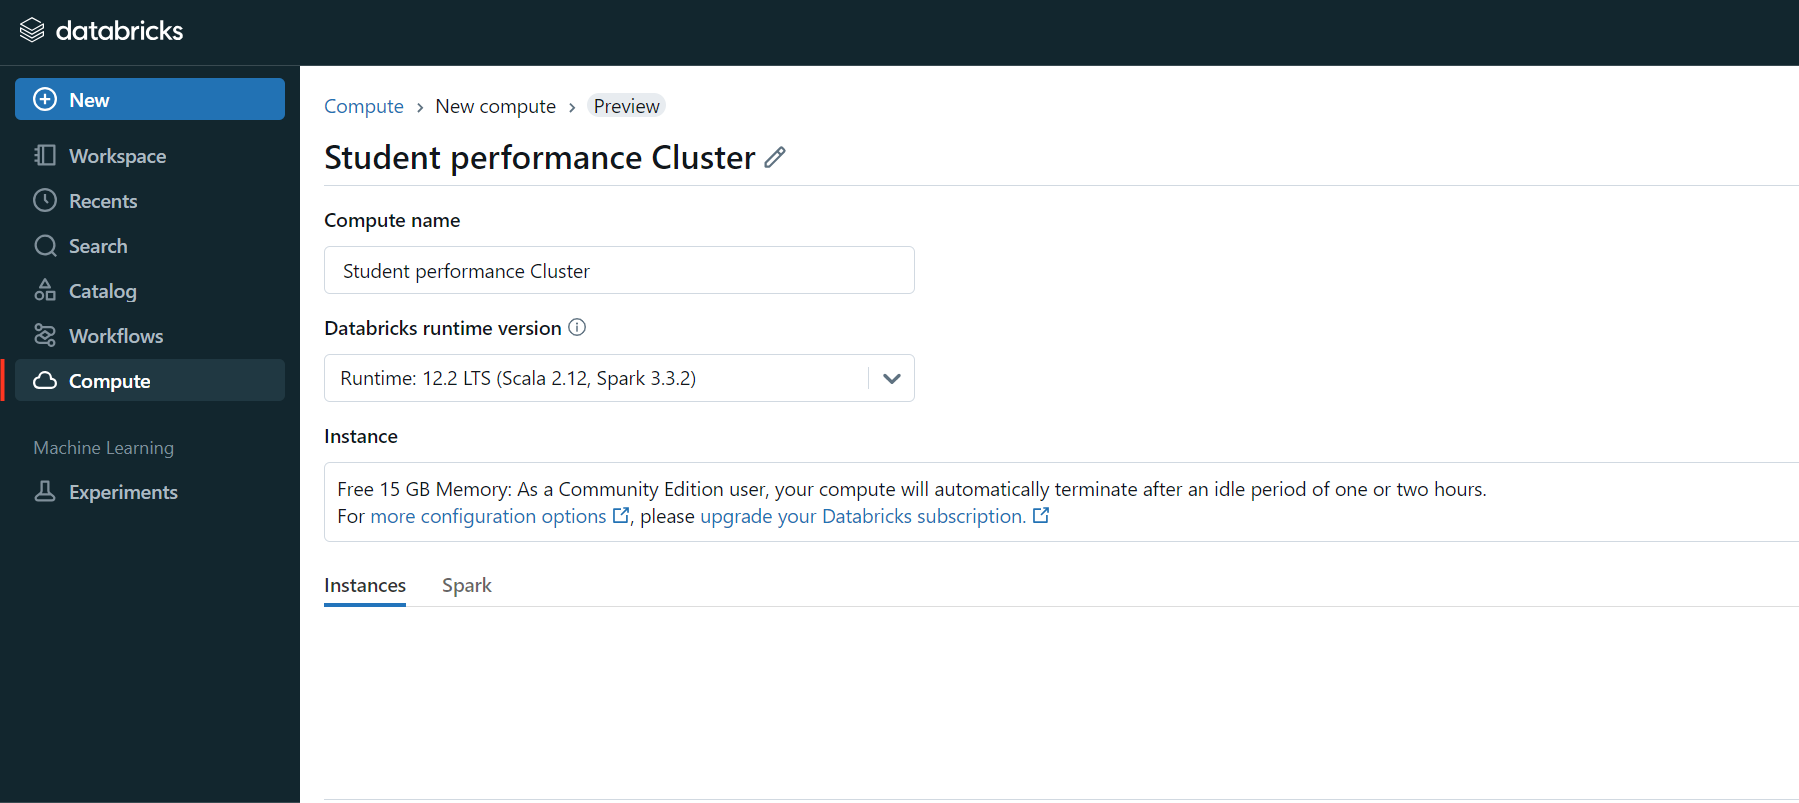

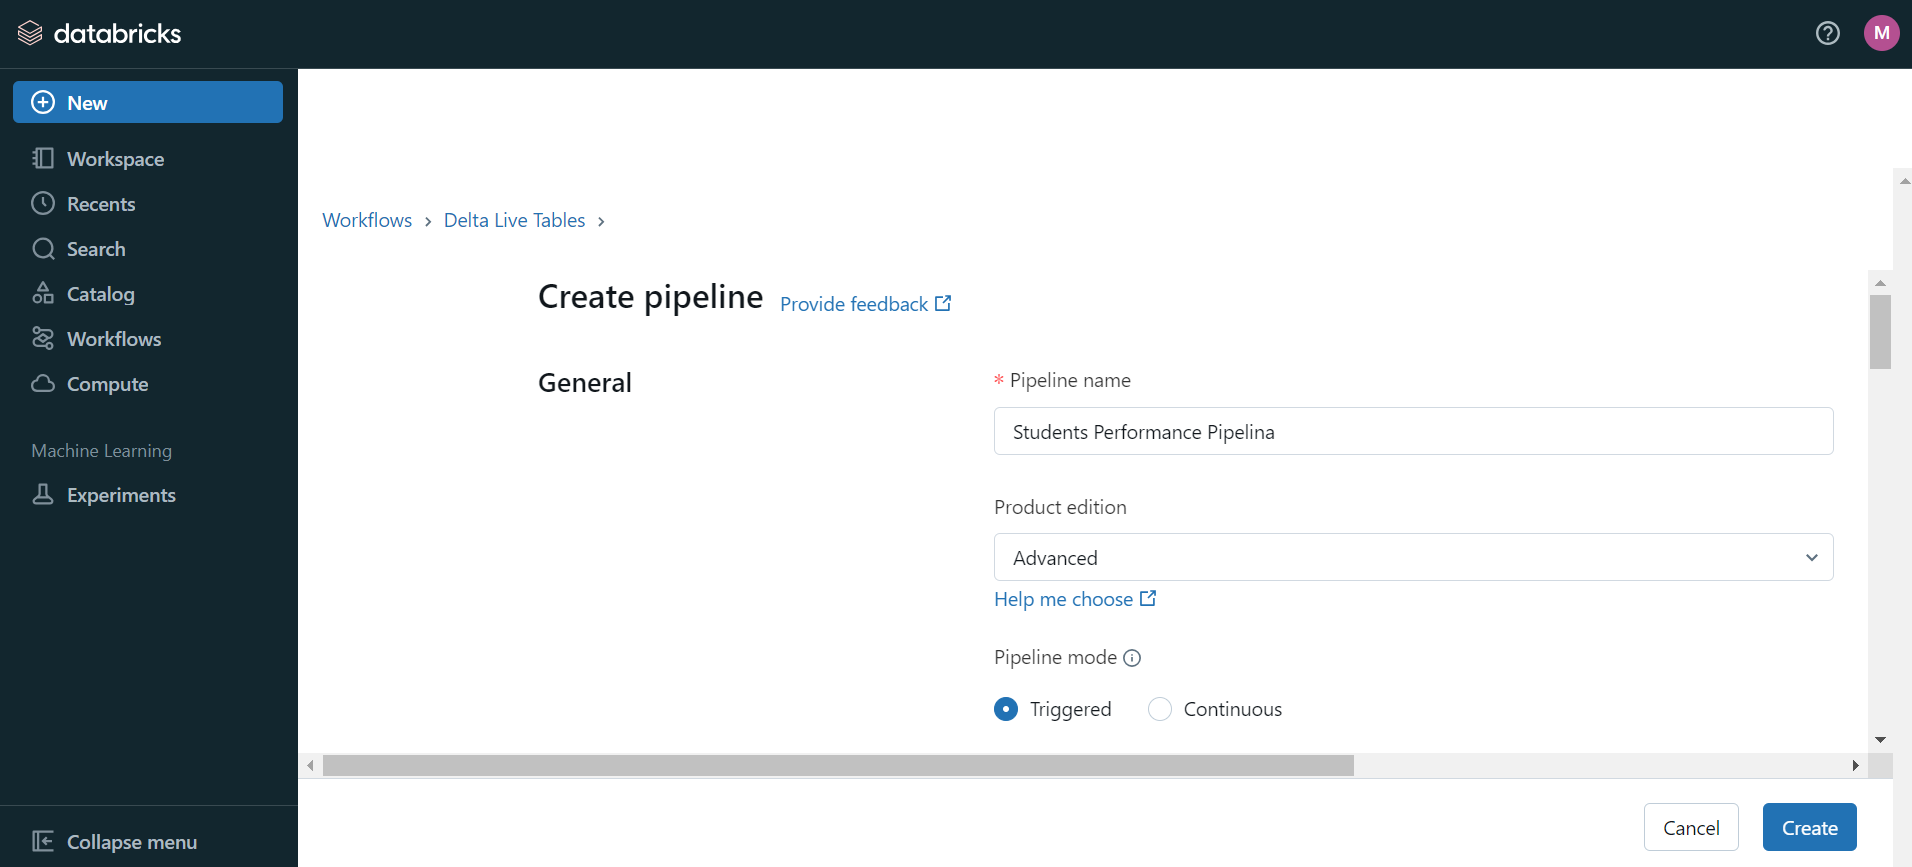


## 4.1. Data Quality

In preparation for data cleaning, specific columns are identified that may contain zero values or outliers needing removal or filtering. These columns include 'Age', 'StudyTimeWeekly', 'Absences', and 'GPA'. Cleaning these columns ensures that only valid and relevant data points are retained for subsequent analysis.

In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType

# Create a Spark session
spark = SparkSession.builder \
    .appName("Loading Student Data") \
    .getOrCreate()


In [ ]:
# Define the data schema
schema = StructType([
    StructField("StudentID", IntegerType(), True),
    StructField("Age", IntegerType(), True),
    StructField("Gender", IntegerType(), True),
    StructField("Ethnicity", IntegerType(), True),
    StructField("ParentalEducation", IntegerType(), True),
    StructField("StudyTimeWeekly", FloatType(), True),
    StructField("Absences", IntegerType(), True),
    StructField("Tutoring", IntegerType(), True),
    StructField("ParentalSupport", IntegerType(), True),
    StructField("Extracurricular", IntegerType(), True),
    StructField("Sports", IntegerType(), True),
    StructField("Music", IntegerType(), True),
    StructField("Volunteering", IntegerType(), True),
    StructField("GPA", FloatType(), True),
    StructField("GradeClass", FloatType(), True)
])


In [ ]:
# Path to the CSV file
file_path = "/FileStore/tables/Student_performance_dataset-1.csv"

# Load data from CSV into DataFrame
df = spark.read.csv(file_path, header=True, schema=schema)


In [ ]:
# Remove rows where specific columns have zero values or values that should not be in the base
df_cleaned = df[
    (df['Age'] >= 15) & (df['Age'] <= 18) &  # Filter valid age range
    (df['StudyTimeWeekly'] >= 0) &  # Assuming weekly study time cannot be negative
    (df['Absences'] >= 0) & (df['Absences'] <= 30) &  # Valid range for absences
    (df['GPA'] >= 0.0) & (df['GPA'] <= 4.0)  # Valid GPA range
]

# Drop rows with NaN values in specific columns
df_cleaned = df_cleaned.dropna(subset=['Age', 'StudyTimeWeekly', 'Absences', 'GPA'])

# Displaying the first 5 rows of cleaned DataFrame
display(df_cleaned.limit(5))


StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.9291956,2.0
1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.0429149,1.0
1003,15,0,2,3,4.21057,26,0,2,0,0,0,0,0.112602256,4.0
1004,17,1,0,3,10.02883,14,0,3,1,0,0,0,2.054218,3.0
1005,17,1,0,2,4.6724954,17,1,3,0,0,0,0,1.2880611,4.0


## 4.2. Data analysis

### a) Academic Performance among Different Demographic Groups

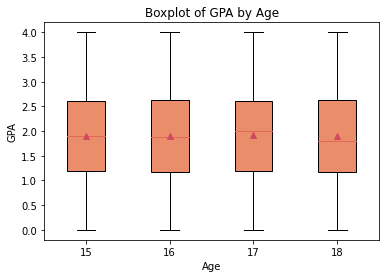

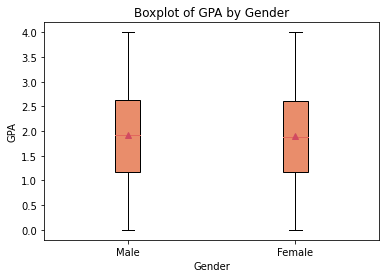

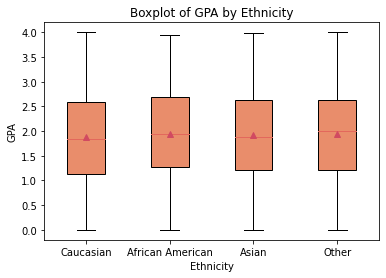

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Defining the color palette
sns.set_palette("flare")  # Choosing the 'flare' palette from seaborn

# Generating data for the Age boxplot
data_age = df.select('Age', 'GPA').toPandas()

# Plotting the Age boxplot
plt.figure(figsize=(6, 4))
plt.boxplot([data_age[data_age['Age'] == age]['GPA'] for age in sorted(data_age['Age'].unique())],
            labels=sorted(data_age['Age'].unique()), patch_artist=True, showmeans=True)
plt.xlabel('Age')
plt.ylabel('GPA')
plt.title('Boxplot of GPA by Age')
plt.show()


# Generating data for the Gender boxplot
data_gender = df.select('Gender', 'GPA').toPandas()

# Plotting the Gender boxplot
plt.figure(figsize=(6, 4))
plt.boxplot([data_gender[data_gender['Gender'] == gender]['GPA'] for gender in sorted(data_gender['Gender'].unique())],
            labels=['Male', 'Female'], patch_artist=True, showmeans=True)
plt.xlabel('Gender')
plt.ylabel('GPA')
plt.title('Boxplot of GPA by Gender')
plt.show()


# Generating data for the Ethnicity boxplot
data_ethnicity = df.select('Ethnicity', 'GPA').toPandas()

# Plotting the Ethnicity boxplot
plt.figure(figsize=(6, 4))
plt.boxplot([data_ethnicity[data_ethnicity['Ethnicity'] == eth]['GPA'] for eth in sorted(data_ethnicity['Ethnicity'].unique())],
            labels=['Caucasian', 'African American', 'Asian', 'Other'], patch_artist=True, showmeans=True)
plt.xlabel('Ethnicity')
plt.ylabel('GPA')
plt.title('Boxplot of GPA by Ethnicity')
plt.show()



### b) Weekly Study Time vs. Academic Performance

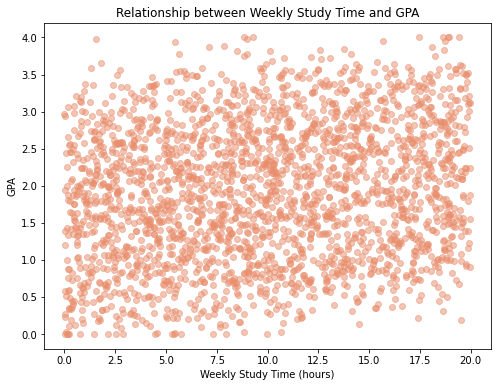

In [ ]:
# Plotting a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df.select('StudyTimeWeekly').collect(), df.select('GPA').collect(), alpha=0.5)
plt.xlabel('Weekly Study Time (hours)')
plt.ylabel('GPA')
plt.title('Relationship between Weekly Study Time and GPA')
plt.show()


### c) Impact of Parental Support on Academic Performance

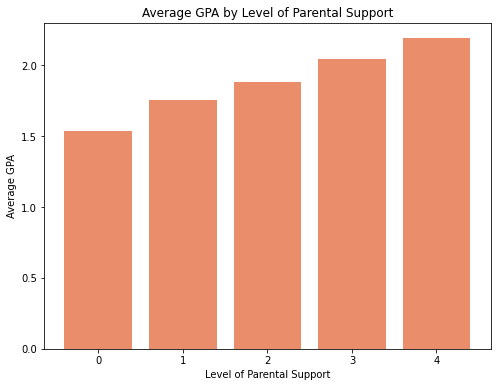

In [ ]:
# Grouping by level of parental support and calculating mean GPA
parental_support_gpa = df.groupby('ParentalSupport').agg({'GPA': 'mean'}).toPandas()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(parental_support_gpa['ParentalSupport'], parental_support_gpa['avg(GPA)'])
plt.xlabel('Level of Parental Support')
plt.ylabel('Average GPA')
plt.title('Average GPA by Level of Parental Support')
plt.xticks(parental_support_gpa['ParentalSupport'])
plt.show()


### d) Association between Extracurricular Activities and Academic Performance

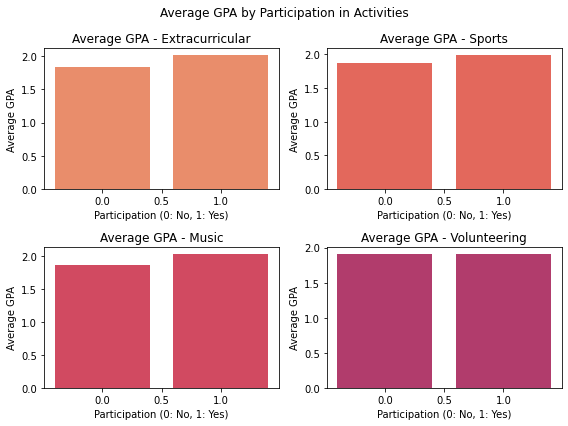

In [ ]:
# Calculating the mean GPA for each activity
activities = ['Extracurricular', 'Sports', 'Music', 'Volunteering']
avg_gpa_activities = [df.groupby(act).agg({'GPA': 'mean'}).orderBy(act).toPandas() for act in activities]

# Plotting bar charts to compare GPA averages
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
fig.suptitle('Average GPA by Participation in Activities')

for i, ax in enumerate(axs.flatten()):
    ax.bar(avg_gpa_activities[i][activities[i]], avg_gpa_activities[i]['avg(GPA)'], color=sns.color_palette()[i])
    ax.set_xlabel('Participation (0: No, 1: Yes)')
    ax.set_ylabel('Average GPA')
    ax.set_title('Average GPA - {}'.format(activities[i]))

plt.tight_layout()
plt.show()


### e) Correlation between Parents' Education Level and Academic Performance

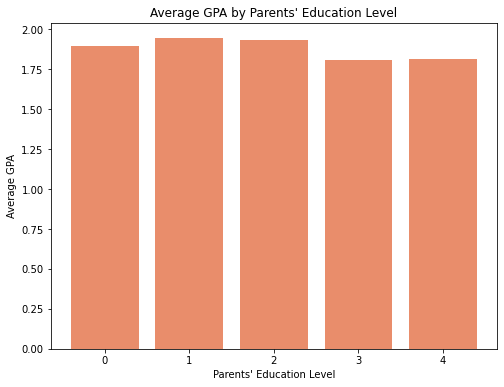

In [ ]:
# Average GPA by parents' education level
parent_education_gpa = df.groupby('ParentalEducation').agg({'GPA': 'mean'}).toPandas()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(parent_education_gpa['ParentalEducation'], parent_education_gpa['avg(GPA)'])
plt.xlabel("Parents' Education Level")
plt.ylabel('Average GPA')
plt.title("Average GPA by Parents' Education Level")
plt.xticks(parent_education_gpa['ParentalEducation'])
plt.show()


### f) Correlation between Absences and Academic Performance

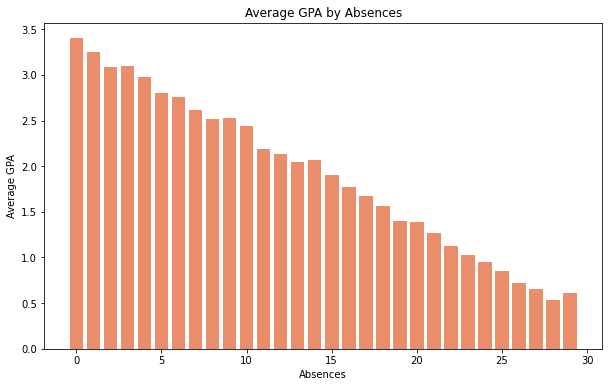

In [ ]:
# Grouping by absences (Absences) and calculating the average GPA
avg_gpa_by_absences = df.groupby('Absences').agg({'GPA': 'mean'}).orderBy('Absences').toPandas()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(avg_gpa_by_absences['Absences'], avg_gpa_by_absences['avg(GPA)'])
plt.xlabel('Absences')
plt.ylabel('Average GPA')
plt.title('Average GPA by Absences')
plt.show()


# 5. Conclusion

Based on the analysis of the data, it becomes evident that some factors play significant roles in influencing students' academic performance in high school. Among these factors, parental support emerges as a crucial determinant, showing a clear positive correlation with higher grades. Students who receive greater support from their parents tend to perform better academically compared to those who receive less support.

Additionally, the number of absences also proves to be a critical factor affecting academic outcomes. Students with fewer absences generally demonstrate higher academic performance levels, indicating a strong negative correlation between attendance and grades.

Other factors such as demographic variables (age, gender, and ethnicity) did not show significant differences in academic performance in this study. Similarly, while extracurricular activities, weekly study time, and parents' education level are important aspects of a student's academic life, their direct impact on academic performance in this particular dataset was not as pronounced as parental support and attendance.

In conclusion, based on the analyzed data, parental support and attendance are the primary factors that consistently influence students' academic performance in high school. Ensuring adequate parental involvement and promoting good attendance habits among students are crucial strategies for enhancing educational outcomes.